In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize
import hdbscan
import seaborn as sns
from matplotlib import pyplot as plt

import sys
sys.path.append("../resources/")
import sct

In [2]:
adata = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')

In [3]:
df_libs = pd.read_csv("../data/libs.csv", sep="\t", header=0, index_col=0) # sample info

In [4]:
df = adata.to_df().T

In [5]:
df = df.fillna(0)
X = df

# Identify marker genes using ICIM (option 1)

In [7]:
import importlib
importlib.reload(sct)
myICIM = sct.ICIM(X, df, TFs=[], CSMs=[], exclude=[], N=100,
                  correlation_cutoff=0.5,
                  min_hits=3,
                  exclude_max=2,
                  dropout_rate_low=0.3,
                  dropout_rate_high=1.0,
                  metric="correlation",
                  stop_condition="linkage_dist",
                  N_stop=50,
                  linkage_dist_stop=0.2)

In [14]:
myICIM.calc(verbose=True)

Initial step
Found 112 genes
Child populations 3516 117

01
Found 50 genes
Child populations 116 1

010
Found 57 genes
Child populations 92 24

0101
Found 420 genes
Failed linkage distance condition. Stopping.

0100
Found 82 genes
Child populations 89 3

01000
Found 64 genes
Child populations 74 15

010000
Found 51 genes
Child populations 73 1

0100000
Found 60 genes
Child populations 72 1

01000000
Found 59 genes
Child populations 71 1

010000000
Found 62 genes
Child populations 14 57

0100000001
Found 182 genes
Failed linkage distance condition. Stopping.

00
Found 92 genes
Child populations 3513 3

000
Found 92 genes
Child populations 3512 1

0000
Found 91 genes
Child populations 3505 7

00000
Found 86 genes
Child populations 3504 1

000000
Found 86 genes
Child populations 3503 1

0000000
Found 86 genes
Child populations 3502 1

00000000
Found 86 genes
Child populations 2062 1440

000000000
Found 34 genes
Child populations 2000 62

0000000000
Found 33 genes
Child populations 1869 13

In [15]:
genes_GH146_ICIM = myICIM.get_all_markers()
print("Genes found by ICIM", len(genes_GH146_ICIM))

Genes found by ICIM 1216


In [ ]:
# save ICIM genes
with open("../data/ICIM_genes/genes_ICIM_all_stages.txt", 'w') as out:
    for x in genes_GH146_ICIM.index:
        out.write(x + "\n")

# Or directly import previously calculated ICIM genes (option 2)

In [11]:
# or directly import if code has been run before
genes_GH146_ICIM = []
with open("../data/ICIM_genes/genes_ICIM_all_stages.txt") as f:
    for line in f:
        genes_GH146_ICIM.append(line.rstrip())
print(len(genes_GH146_ICIM))

1216


In [12]:
adata.obs.stage.value_counts()

0h       1158
24h       946
48h       888
adult     641
Name: stage, dtype: int64

In [13]:
# Subset data to genes desired
Y = X.loc[genes_GH146_ICIM]
import importlib
# Calculate TSNE
importlib.reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(X.loc[genes_GH146_ICIM], X, df_libs)
myTSNE.calc_TSNE(perplexity=80, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 1000 / 3633
[t-SNE] Computed conditional probabilities for sample 2000 / 3633
[t-SNE] Computed conditional probabilities for sample 3000 / 3633
[t-SNE] Computed conditional probabilities for sample 3633 / 3633
[t-SNE] Mean sigma: 0.127715
[t-SNE] Iteration 50: error = 15.5999134, gradient norm = 0.0048196 (50 iterations in 18.062s)
[t-SNE] Iteration 100: error = 15.2030690, gradient norm = 0.0004440 (50 iterations in 18.066s)
[t-SNE] Iteration 150: error = 15.1673491, gradient norm = 0.0000739 (50 iterations in 19.058s)
[t-SNE] Iteration 200: error = 15.1630532, gradient norm = 0.0000207 (50 iterations in 22.492s)
[t-SNE] Iteration 250: error = 15.1624500, gradient norm = 0.0000134 (50 iterations in 24.054s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 15.162450
[t-SNE] Iteration 300: error = 1.3828814, gradient norm = 0.0007377 (50 iterations in 23.135s)
[t-SNE] Iteration 350: error = 1.2379773, gradient norm

In [14]:
adata.obsm['X_tsne'] = myTSNE.X_tsne

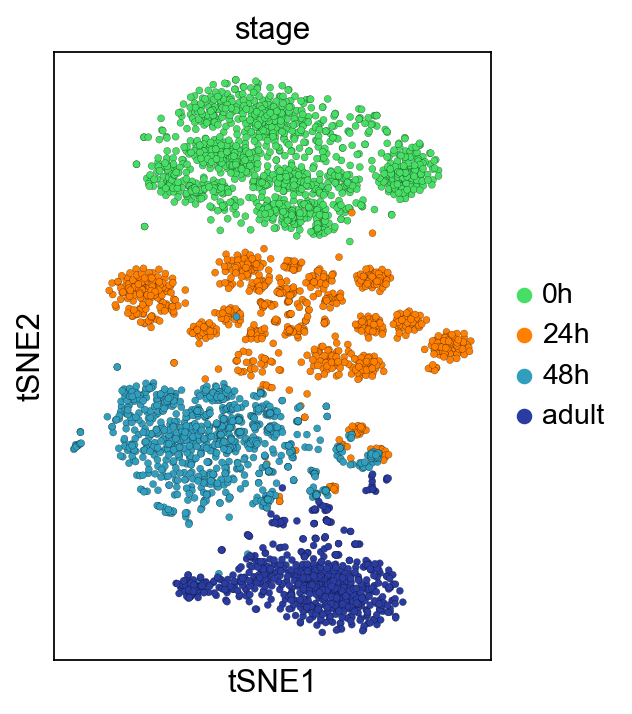

In [15]:
sc.set_figure_params(figsize=(3.5,5),dpi_save=600)
sc.pl.tsne(adata,color='stage', size=(40,40), edgecolor="k", linewidths=0.1)#,save='_prep80_edge_stage.pdf')

# Identify differentially expressed (DE) genes

In [16]:
names_0h = list(adata[adata.obs['stage'] == '0h'].obs_names)
names_24h = list(adata[adata.obs['stage'] == '24h'].obs_names)
names_48h = list(adata[adata.obs['stage'] == '48h'].obs_names)
names_adult = list(adata[adata.obs['stage'] == 'adult'].obs_names)

In [17]:
df = adata.to_df().T

Identifying Differentially expressed genes between any two pairs

In [18]:
# df_DE_0h_24h = sct.calc_DE_mannwhitneyu(df, names_0h, names_24h)
# df_DE_0h_24h.to_csv("../to_upload/data_PN/df_DE_0h_24h.csv")
df_DE_0h_24h = pd.read_csv("../output/global_DE/df_DE_0h_24h.csv", sep=",", header=0, index_col=0) # sample info

In [19]:
# df_DE_0h_48h = sct.calc_DE_mannwhitneyu(df, names_0h, names_48h)
# df_DE_0h_48h.to_csv("../to_upload/data_PN/df_DE_0h_48h.csv")
df_DE_0h_48h = pd.read_csv("../output/global_DE/df_DE_0h_48h.csv", sep=",", header=0, index_col=0) # sample info

In [20]:
# df_DE_0h_adult = sct.calc_DE_mannwhitneyu(df, names_0h, names_adult)
# df_DE_0h_adult.to_csv("../to_upload/data_PN/df_DE_0h_adult.csv")
df_DE_0h_adult = pd.read_csv("../output/global_DE/df_DE_0h_adult.csv", sep=",", header=0, index_col=0) # sample info

In [21]:
# df_DE_24h_48h = sct.calc_DE_mannwhitneyu(df, names_24h, names_48h)
# df_DE_24h_48h.to_csv("../to_upload/data_PN/df_DE_24h_48h.csv")
df_DE_24h_48h = pd.read_csv("../output/global_DE/df_DE_24h_48h.csv", sep=",", header=0, index_col=0) # sample info

In [22]:
# df_DE_24h_adult = sct.calc_DE_mannwhitneyu(df, names_24h, names_adult)
# df_DE_24h_adult.to_csv("../to_upload/data_PN/df_DE_24h_adult.csv")
df_DE_24h_adult = pd.read_csv("../output/global_DE/df_DE_24h_adult.csv", sep=",", header=0, index_col=0) # sample info/

In [23]:
# df_DE_48h_adult = sct.calc_DE_mannwhitneyu(df, names_48h, names_adult)
# df_DE_48h_adult.to_csv("../to_upload/data_PN/df_DE_48h_adult.csv")
df_DE_48h_adult = pd.read_csv("../output/global_DE/df_DE_48h_adult.csv", sep=",", header=0, index_col=0) # sample info

In [24]:
Number_genes = 30
names_df_DE_0h_24h = df_DE_0h_24h.index[0:Number_genes]
names_df_DE_0h_48h = df_DE_0h_48h.index[0:Number_genes]
names_df_DE_0h_adult = df_DE_0h_adult.index[0:Number_genes]
names_df_DE_24h_48h = df_DE_24h_48h.index[0:Number_genes]
names_df_DE_24h_adult = df_DE_24h_adult.index[0:Number_genes]
names_df_DE_48h_adult = df_DE_48h_adult.index[0:Number_genes]

combined_DE_genes = set(list(names_df_DE_0h_24h)+list(names_df_DE_0h_48h)+list(names_df_DE_0h_adult)+
                       list(names_df_DE_24h_48h)+list(names_df_DE_24h_adult)+list(names_df_DE_48h_adult))

In [25]:
Z = df.loc[combined_DE_genes]
Z.shape

(100, 3633)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


[]

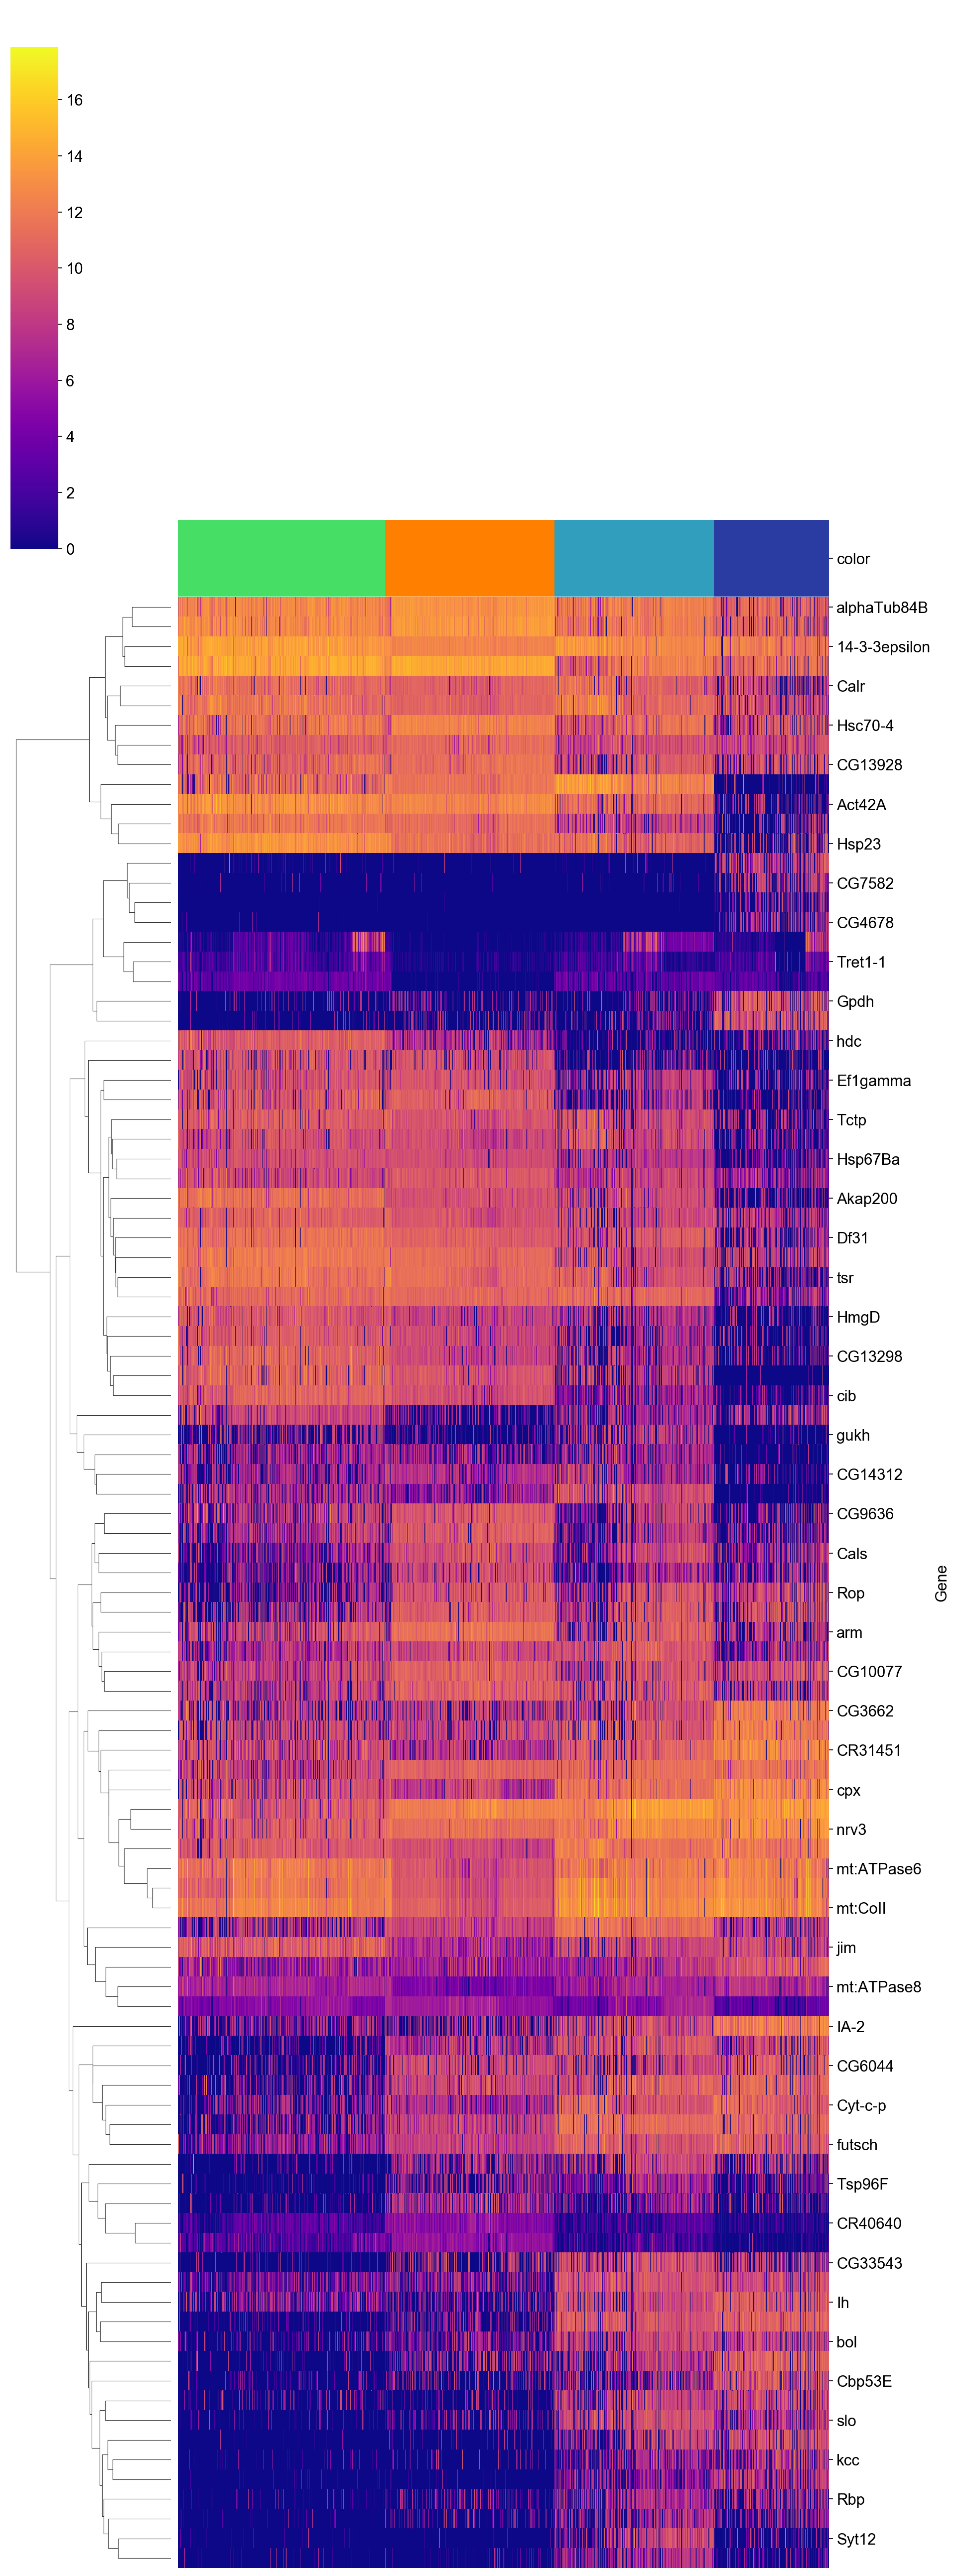

In [26]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["color"]

cm = sns.clustermap(Z, method="weighted", cmap="plasma", col_colors=col_colors, figsize=(12,35),row_cluster=True, col_cluster=False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
# cm.savefig('top_100.pdf')

In [27]:
Number_genes = 15
names_df_DE_0h_24h = df_DE_0h_24h.index[0:Number_genes]
names_df_DE_0h_48h = df_DE_0h_48h.index[0:Number_genes]
names_df_DE_0h_adult = df_DE_0h_adult.index[0:Number_genes]
names_df_DE_24h_48h = df_DE_24h_48h.index[0:Number_genes]
names_df_DE_24h_adult = df_DE_24h_adult.index[0:Number_genes]
names_df_DE_48h_adult = df_DE_48h_adult.index[0:Number_genes]

combined_DE_genes = set(list(names_df_DE_0h_24h)+list(names_df_DE_0h_48h)+list(names_df_DE_0h_adult)+
                       list(names_df_DE_24h_48h)+list(names_df_DE_24h_adult)+list(names_df_DE_48h_adult))

In [28]:
Z = df.loc[combined_DE_genes]
Z.shape

(52, 3633)

In [29]:
plt.rcParams.update({'font.size': 35})

[]

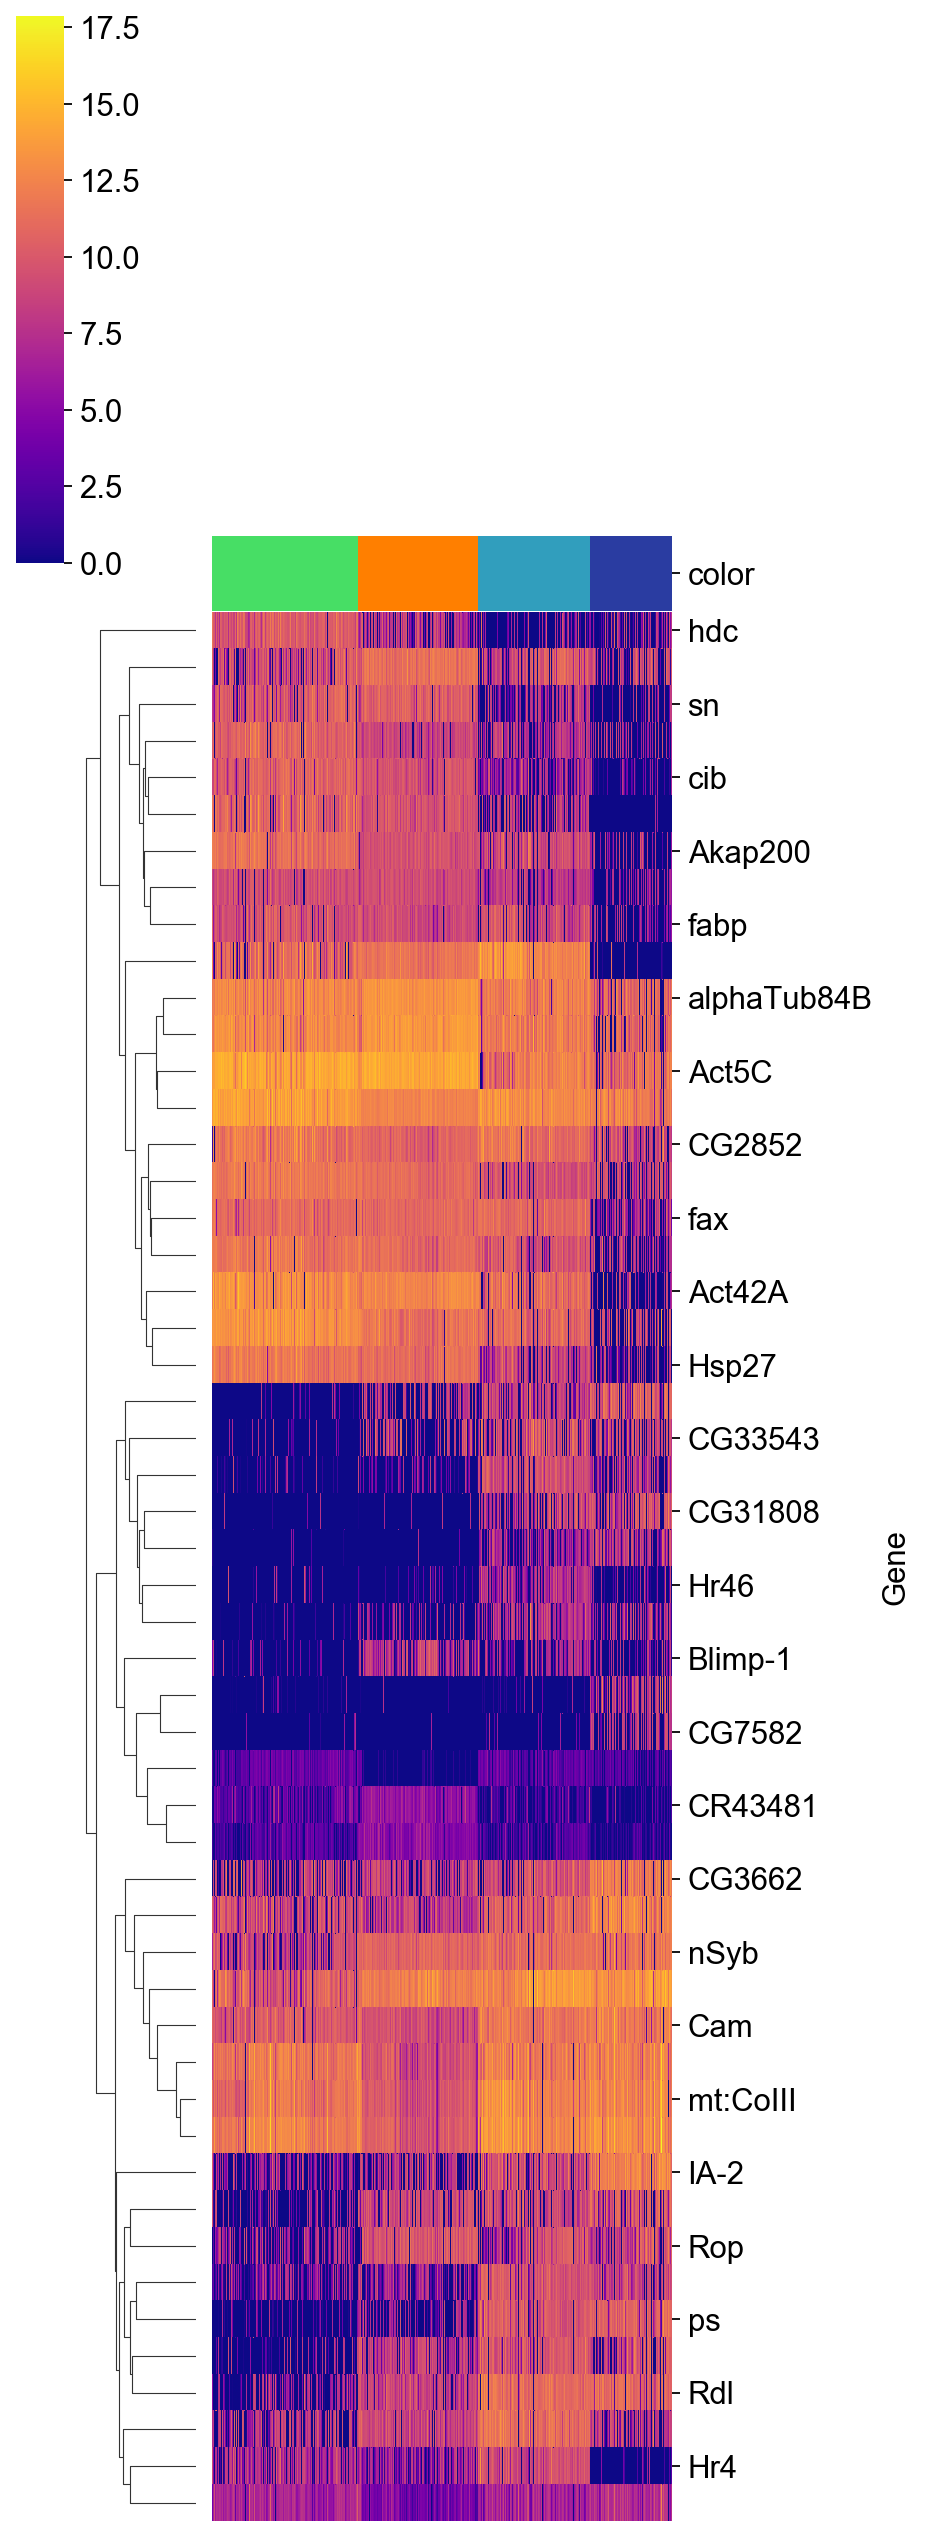

In [30]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["color"]

cm = sns.clustermap(Z, method="weighted", cmap="plasma", col_colors=col_colors, figsize=(6,19),row_cluster=True, col_cluster=False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
# cm.savefig('top_52_2.pdf')

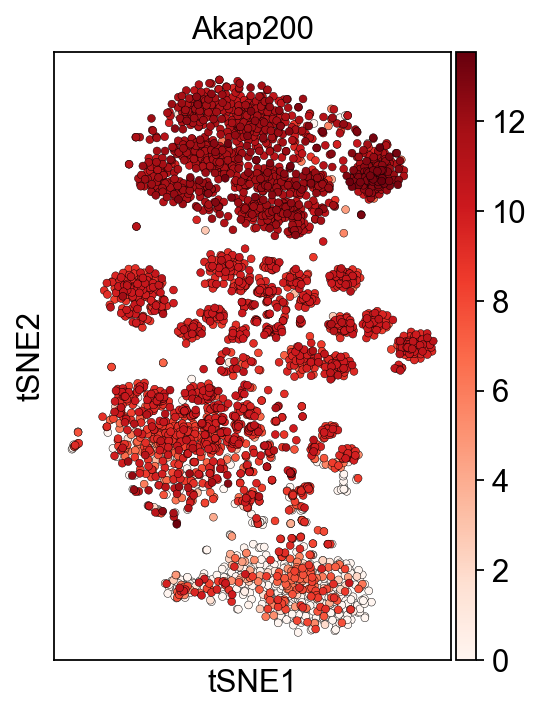

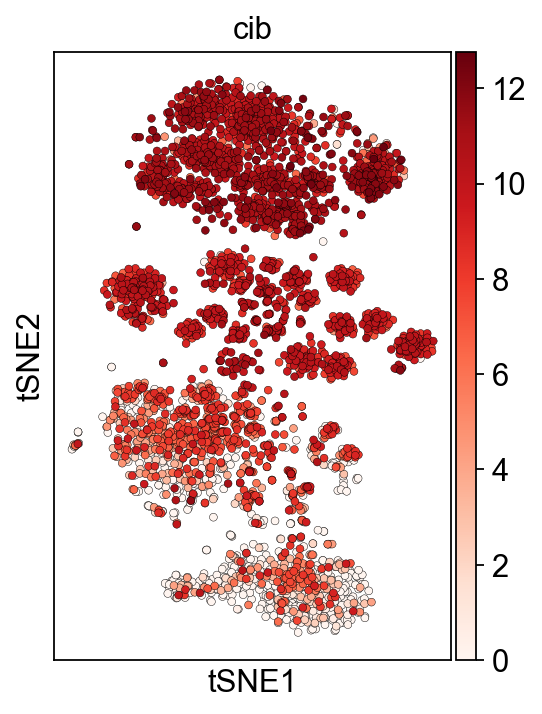

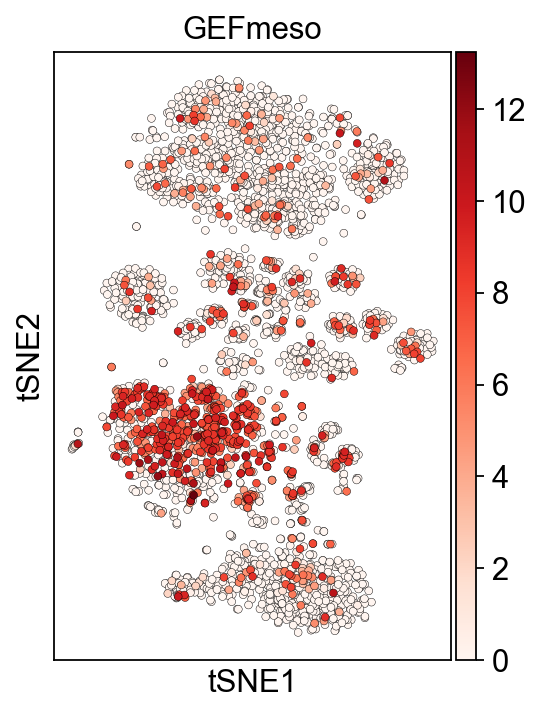

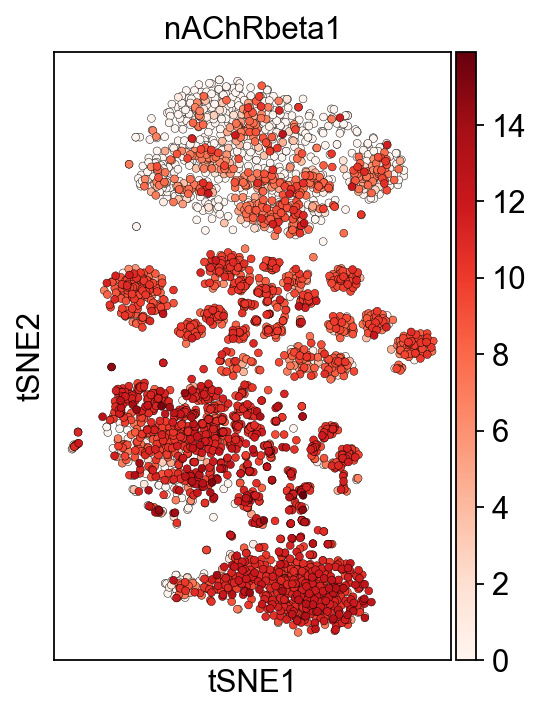

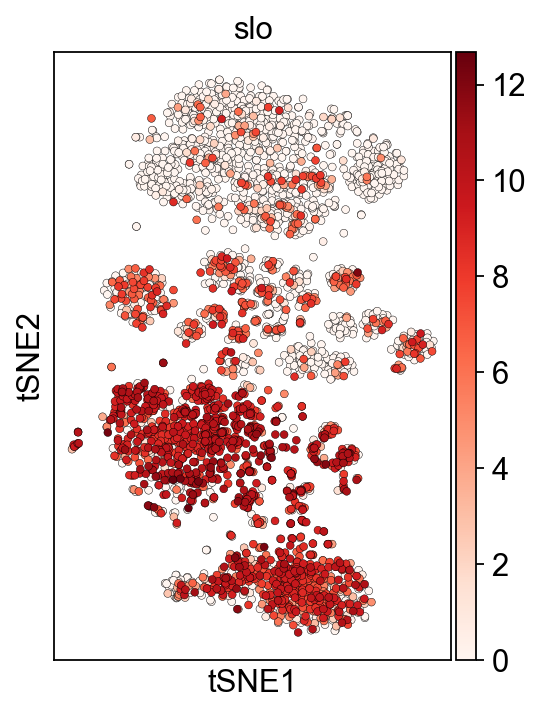

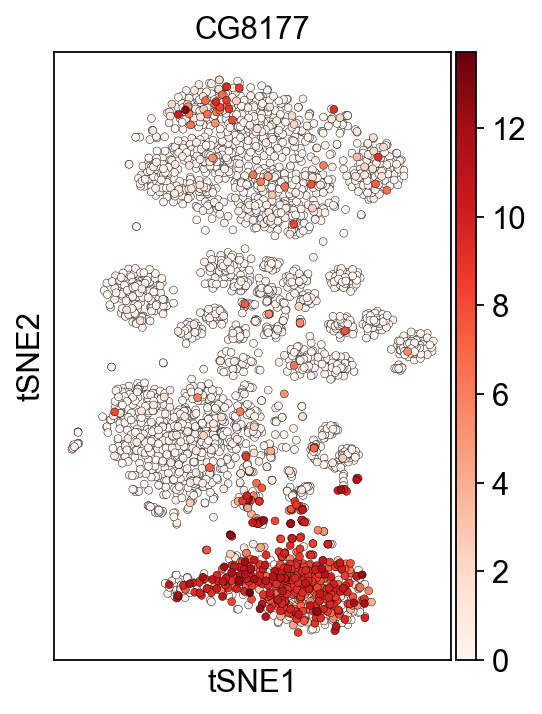

In [31]:
MyGenes = ['Akap200','cib','GEFmeso','nAChRbeta1','slo','CG8177']
sc.set_figure_params(figsize=(3.5,5),dpi_save=600)
for gene in MyGenes:
    sc.pl.tsne(adata, color=gene, size=(50,50), edgecolor="k", linewidths=0.2,
               color_map="Reds")#, save= '_'+gene+'.pdf')

# dynamic genes

In [32]:
def calc_median_for_timepoints(df, df_libs):
    # Calculates median expression of each gene for each time point
    labels = [("0hAPF", "VT_PN_0h"), 
              ("24hAPF", "GH146-GFP"), 
              ("48hAPF", "GH146_48h"),
              ("adult", "GH146_adult")]
    df_aggr = pd.DataFrame()
    for name, label in labels:
        #df_aggr[name] = np.median(df.T.loc[df_libs.loc[df.columns]["label"] == label].T, axis=1)
        df_aggr[name] = np.mean(df.T.loc[df_libs.loc[df.columns]["label"] == label].T, axis=1)
    df_aggr.index = df.index
    return df_aggr

In [33]:
df_timepoints_median = calc_median_for_timepoints(df, df_libs)

In [34]:
# DE genes set
Number_genes = 150
names_df_DE_0h_24h = df_DE_0h_24h.index[0:Number_genes]
names_df_DE_0h_48h = df_DE_0h_48h.index[0:Number_genes]
names_df_DE_0h_adult = df_DE_0h_adult.index[0:Number_genes]
names_df_DE_24h_48h = df_DE_24h_48h.index[0:Number_genes]
names_df_DE_24h_adult = df_DE_24h_adult.index[0:Number_genes]
names_df_DE_48h_adult = df_DE_48h_adult.index[0:Number_genes]

combined_DE_genes = set(list(names_df_DE_0h_24h)+list(names_df_DE_0h_48h)+list(names_df_DE_0h_adult)+
                       list(names_df_DE_24h_48h)+list(names_df_DE_24h_adult)+list(names_df_DE_48h_adult))

print(len(combined_DE_genes))
myGenes = combined_DE_genes

474


In [35]:
X = df_timepoints_median
print(X.shape)

# Filter for genes that are DE between 24h APF and adult
X = X.loc[list(myGenes)]

# Normalize expression of each gene to itself (scales expression at each timepoint between 0 and 1)
X = X.div(X.max(axis=1), axis=0)

print(X.head(5))
print(X.shape)

# Drop rows with NaN
X.dropna(inplace=True)

print(X.shape)

(17474, 4)
           0hAPF    24hAPF    48hAPF     adult
Pde8    0.039715  0.200545  1.000000  0.631051
Eno     0.749464  0.838835  0.702427  1.000000
Cbp53E  0.090229  0.249405  0.593816  1.000000
RpLP1   1.000000  0.938355  0.807572  0.565924
TER94   0.782021  1.000000  0.674696  0.265337
(474, 4)
(474, 4)


In [36]:
# Filter for genes that are expressed in at least 3 cells
df_filtered = df.loc[np.sum(df > 2.0, axis=1) > 3]
print(df_filtered.shape)

# Filter genes for those expressed highly in at least one time point
# X = df_timepoints_median.loc[np.sum(df_timepoints_median > 8, axis=1) > 0]
X = df_timepoints_median

# Normalize expression of each gene to itself (scales expression at each timepoint between 0 and 1)
X = X.div(X.max(axis=1), axis=0)

# Filter for genes with substantial variation across time
# X = X.loc[np.std(X, axis=1) >= 0.05]

# Filter for genes that are DE between 24h APF and adult
X = X.loc[list(myGenes)]

# Drop rows with NaN
X.dropna(inplace=True)

print(X.shape)

(12791, 3633)
(474, 4)


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 474 samples in 0.000s...
[t-SNE] Computed neighbors for 474 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 474 / 474
[t-SNE] Mean sigma: 0.052955
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 28.6144218, gradient norm = 0.2199959 (50 iterations in 0.102s)
[t-SNE] Iteration 100: error = 24.7754250, gradient norm = 0.2262844 (50 iterations in 0.088s)
[t-SNE] Iteration 150: error = 24.0525208, gradient norm = 0.2268215 (50 iterations in 0.087s)
[t-SNE] Iteration 200: error = 23.6391983, gradient norm = 0.2245736 (50 iterations in 0.084s)
[t-SNE] Iteration 250: error = 23.3054047, gradient norm = 0.2260956 (50 iterations in 0.085s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 23.305405
[t-SNE] Iteration 300: error = 0.5152093, gradient norm = 0.0019903 (50 iterations in 0.075s)
[t-SNE] Iteration 350: error = 0.4567264, gradient norm = 0.0007301 (

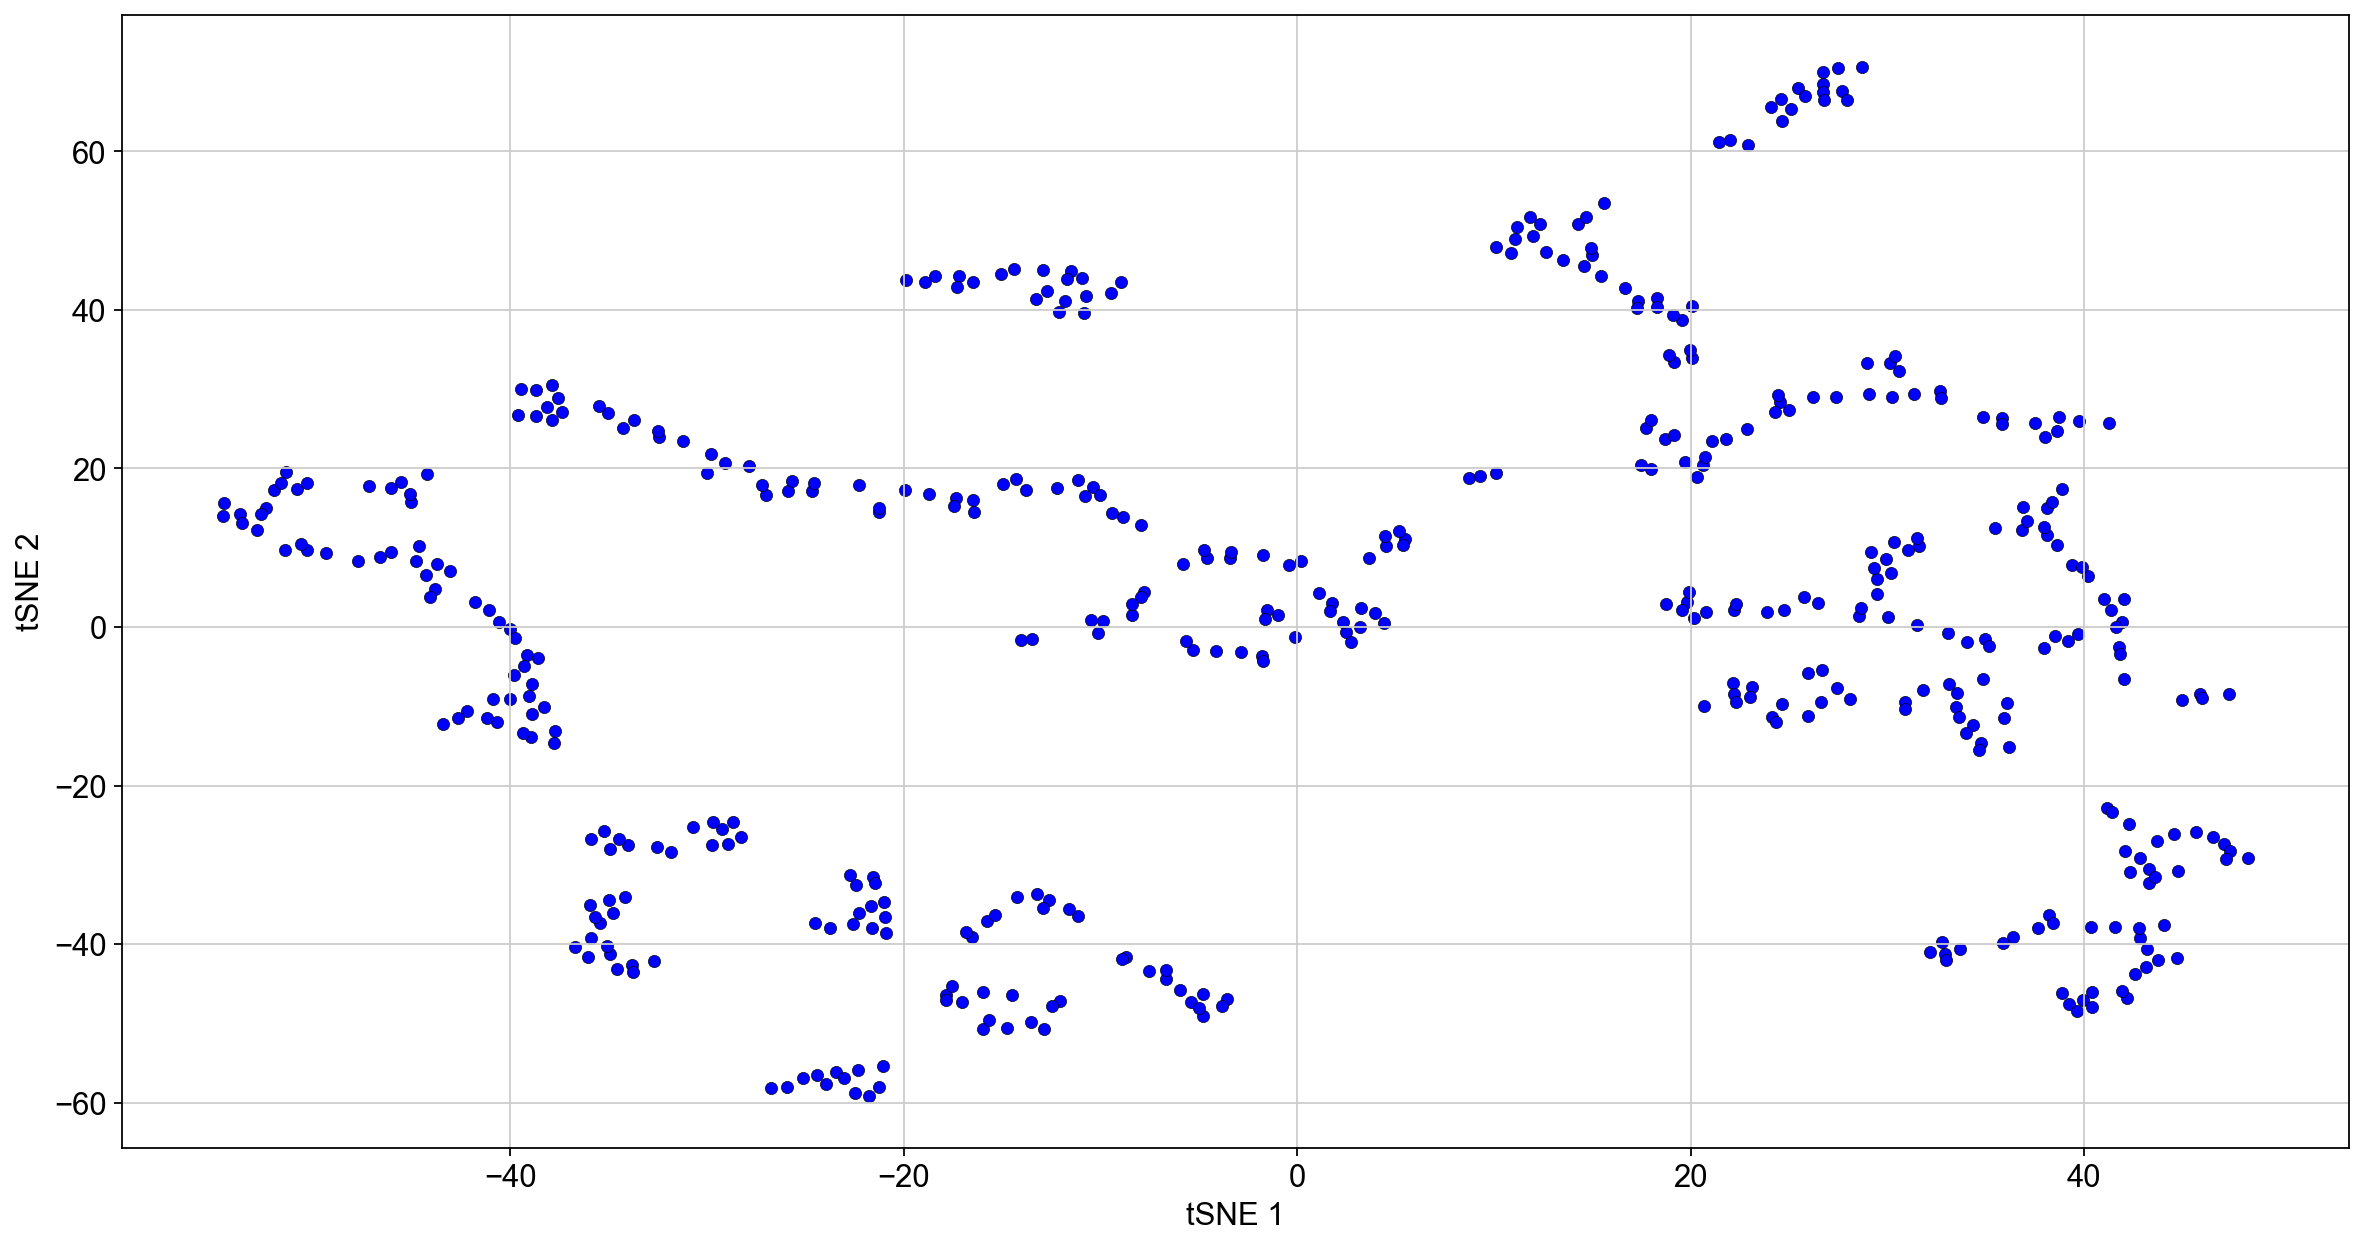

In [37]:
myTSNE = TSNE(n_components=2, metric="correlation",
              perplexity=9, early_exaggeration=6.0,
              learning_rate=500, verbose=2,random_state = 1)
X_TSNE = myTSNE.fit_transform(X)

# Note that clustering is different from that shown in paper because random seed is different
# One can tweak the clustering parameters to achieve homogeneity in dynamical profiles
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], s=30, linewidths=0.3, color="b", edgecolor="k")
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")
plt.tight_layout()

Clusters 9


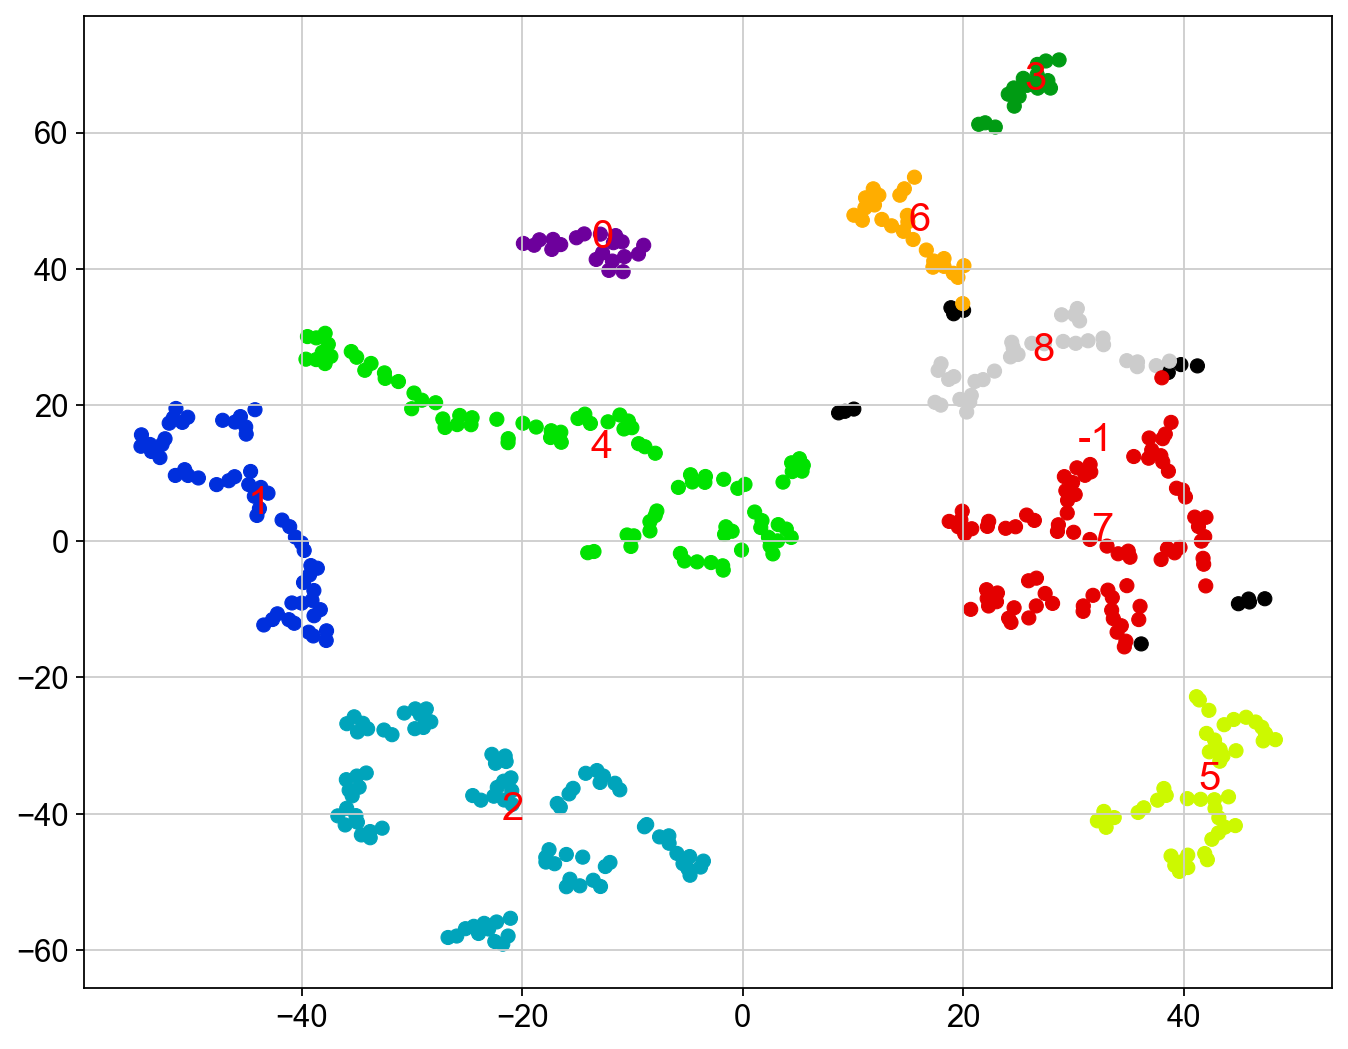

In [38]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=12, min_samples=9).fit(X_TSNE)
labels_HDBSCAN = clusterer.labels_
print("Clusters", max(labels_HDBSCAN)+1)

# Plot TSNE with cluster labels
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=labels_HDBSCAN,  s=40, linewidths=0.5,cmap="nipy_spectral")
for label in pd.Series(labels_HDBSCAN).value_counts().index:
    x_bar = np.mean(X_TSNE[labels_HDBSCAN == label, 0])
    y_bar = np.mean(X_TSNE[labels_HDBSCAN == label, 1])
    ax.text(x_bar, y_bar, label, size=18, color="r")

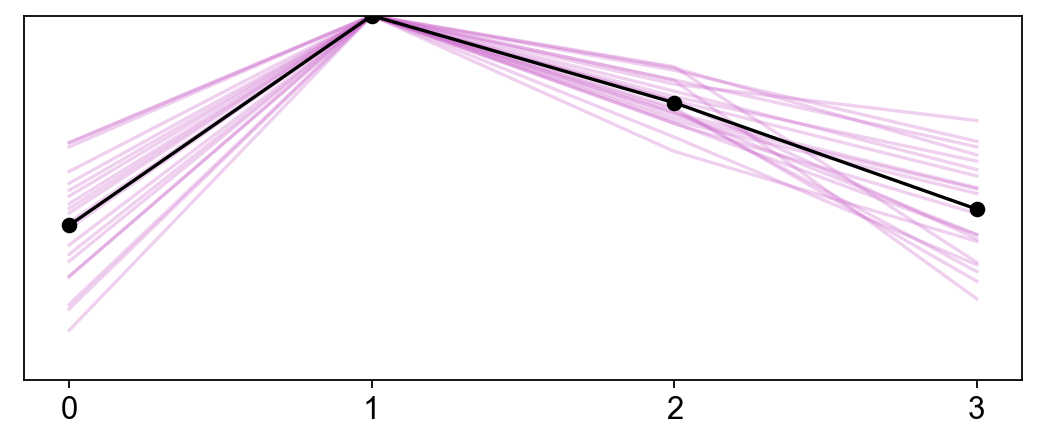

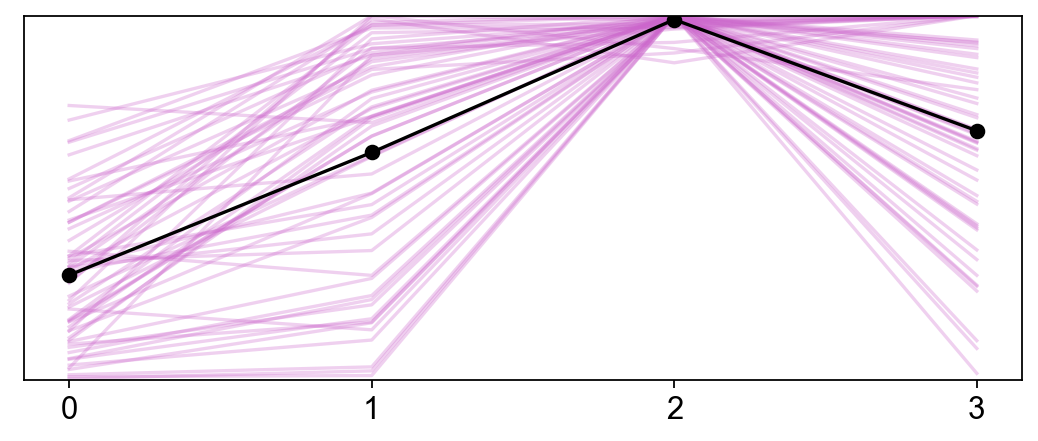

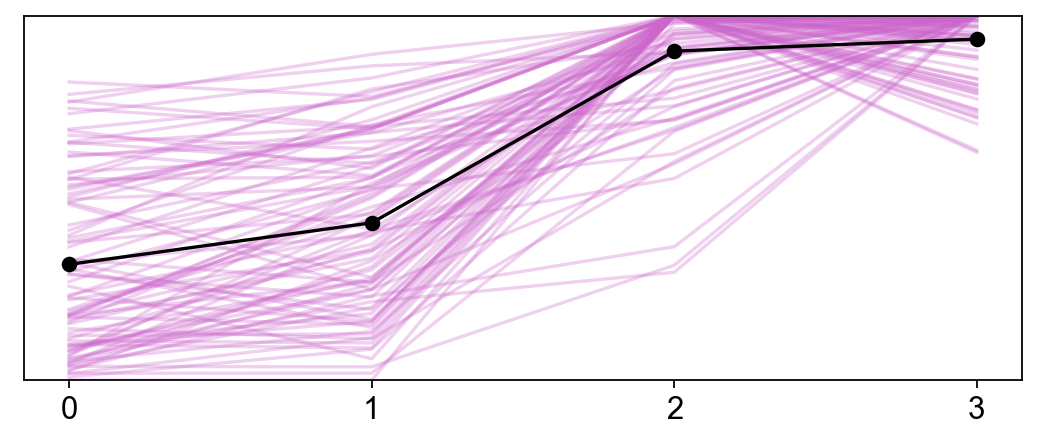

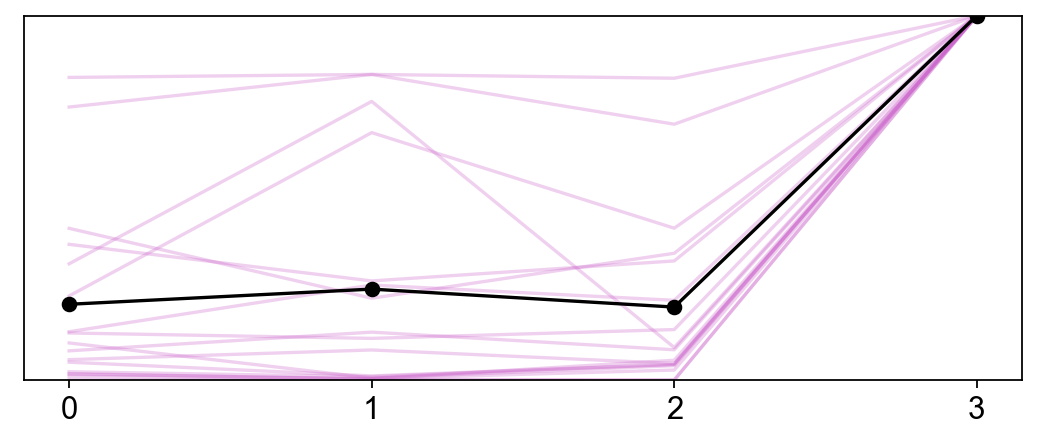

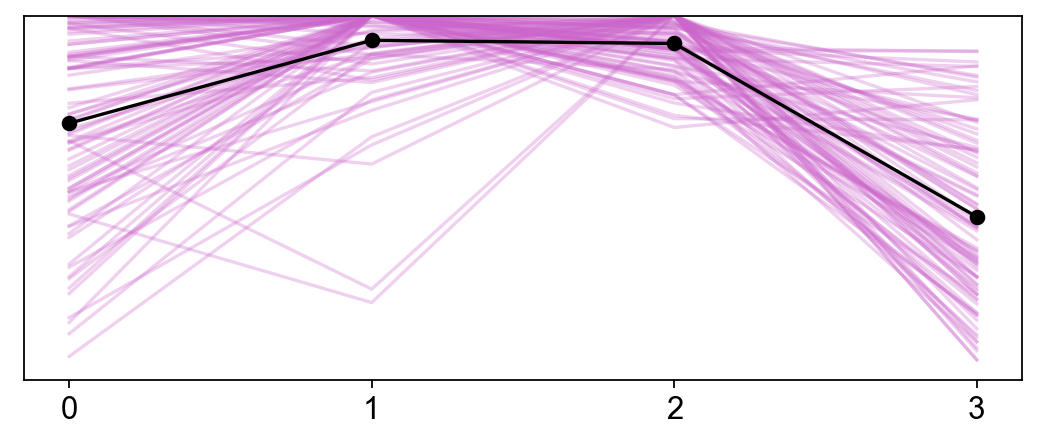

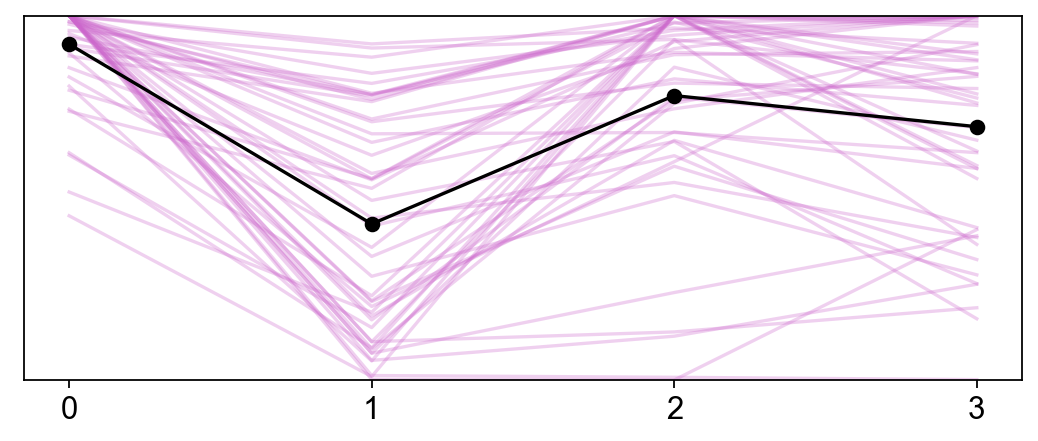

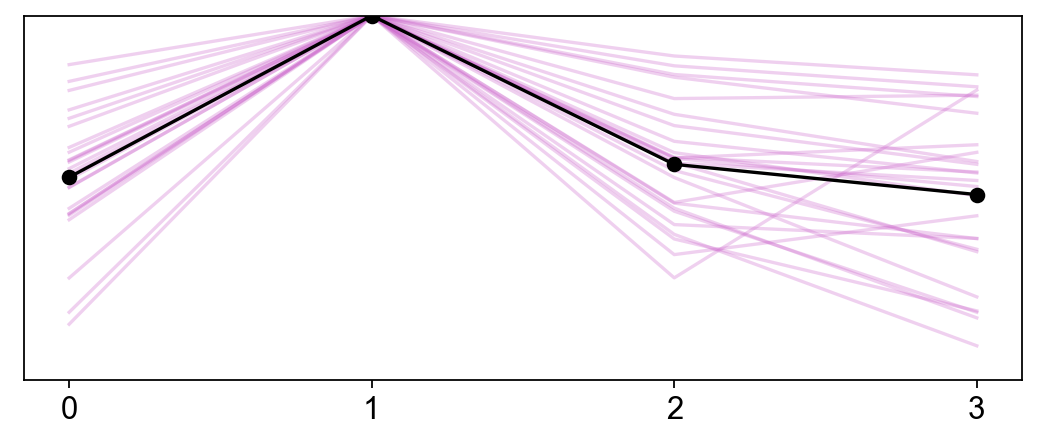

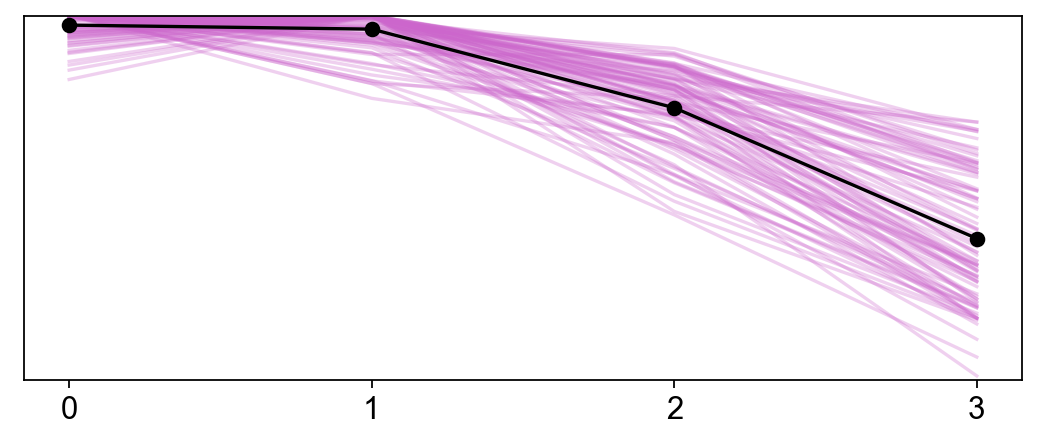

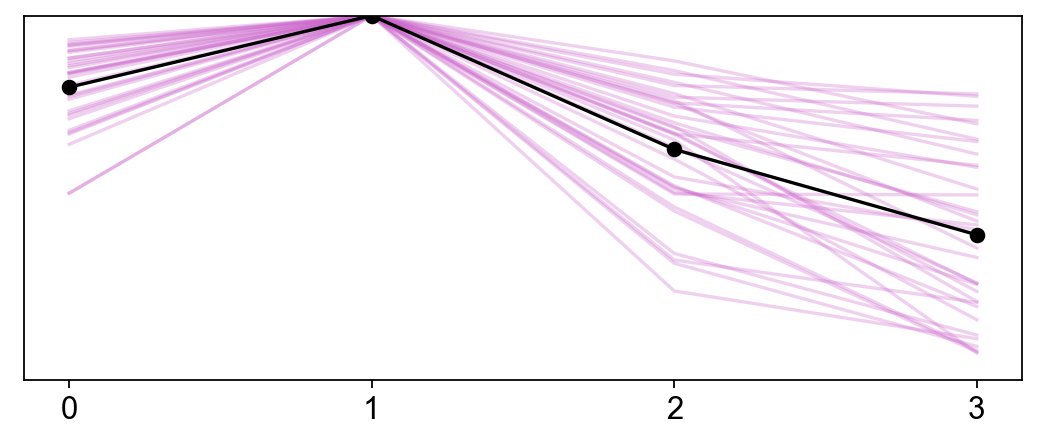

In [40]:
# Plot dynamics of each cluster
for label in range(0, max(labels_HDBSCAN)+1):
    Y = X.loc[labels_HDBSCAN == label]
    
    x = range(4)
    y = np.mean(Y, axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(x, y, marker="o", c="k", zorder=20)
    
    for symbol, row in Y.iterrows():
        ax.plot(x, row, alpha=0.3, c="#cc66cc")
    
    ax.grid(False)
    ax.set_ylim(0,1)
    ax.set_yticks([])
#     ax.set_title("dynamic gene set " + str(label+1) + "  (" + str(Y.shape[0]) + " genes) ",y=1.03,size=20, color ='r')
#     ax.set_ylabel("Relative expression")
    ax.set_xticks(x)
#     ax.set_xticklabels(["0h APF", "24h APF", "48h APF", "adult"],size=20)

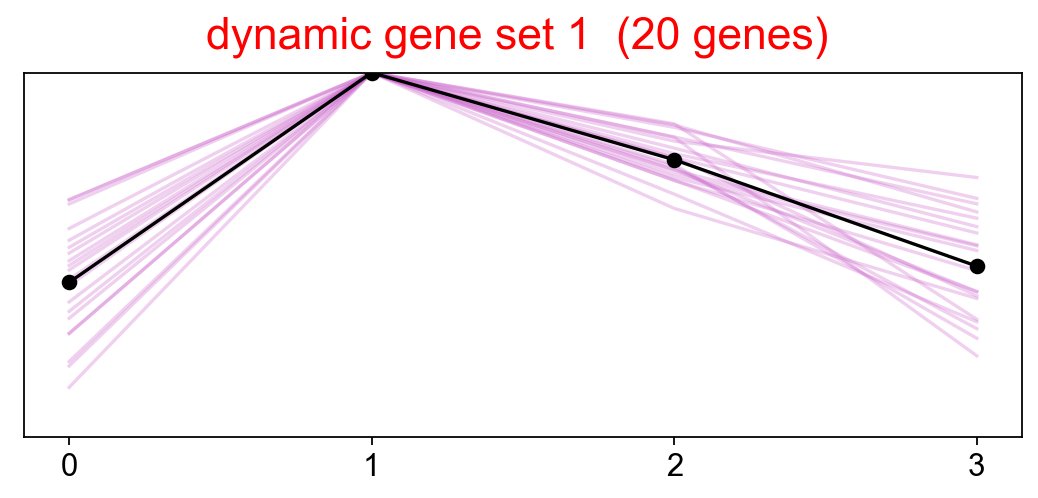

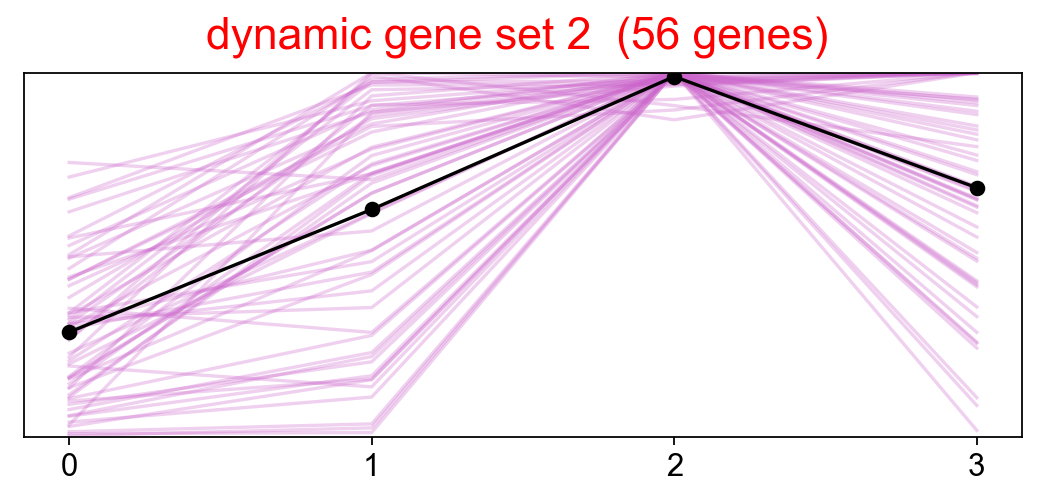

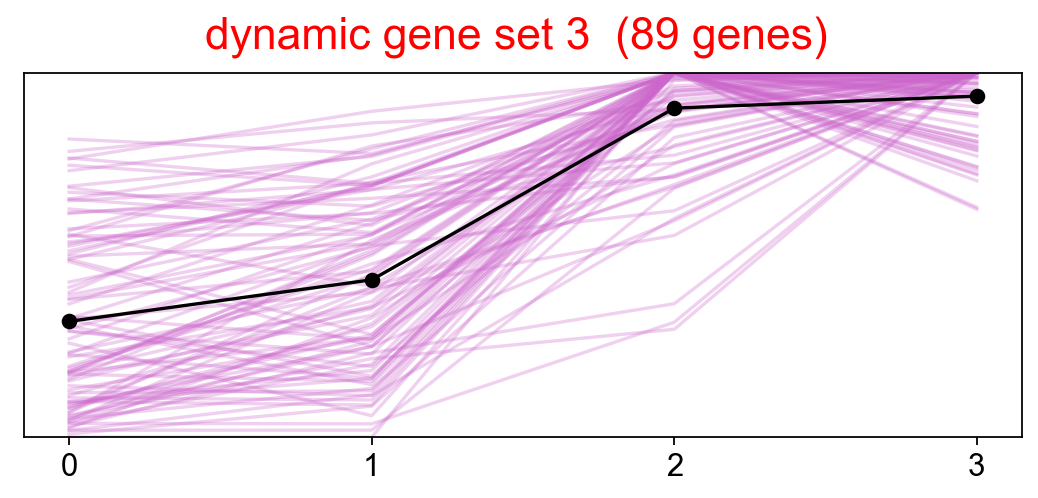

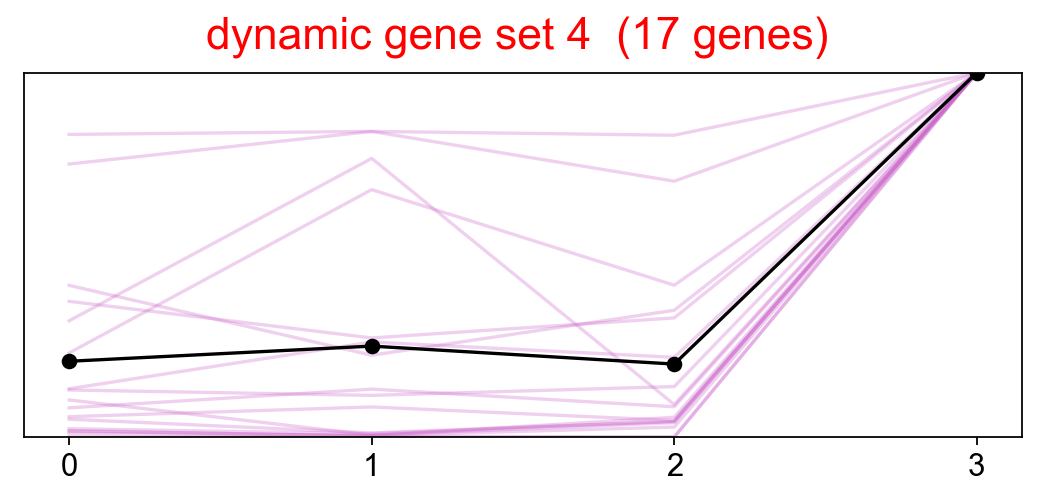

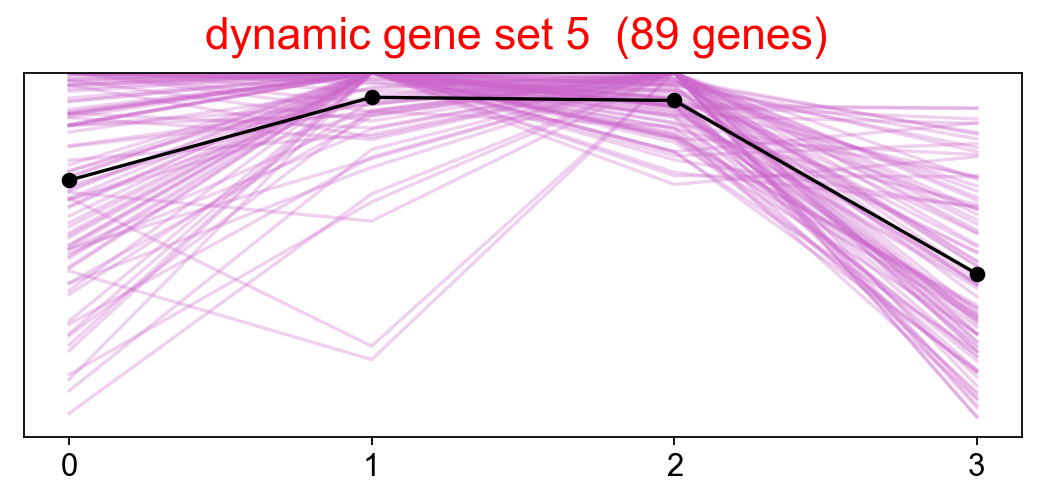

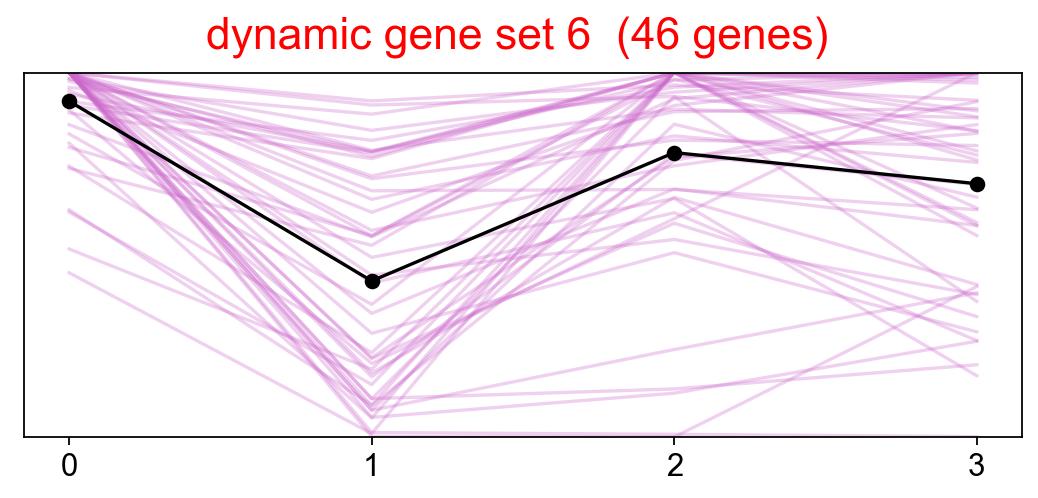

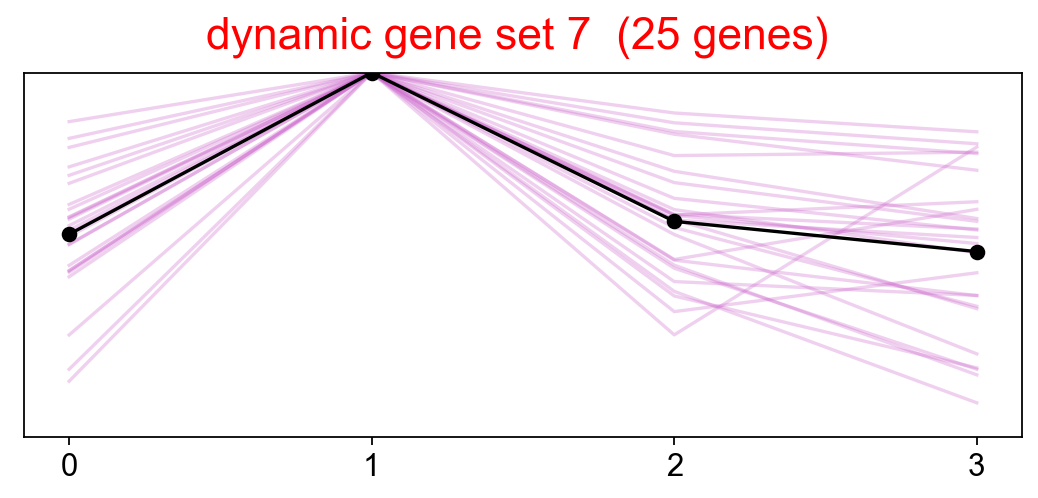

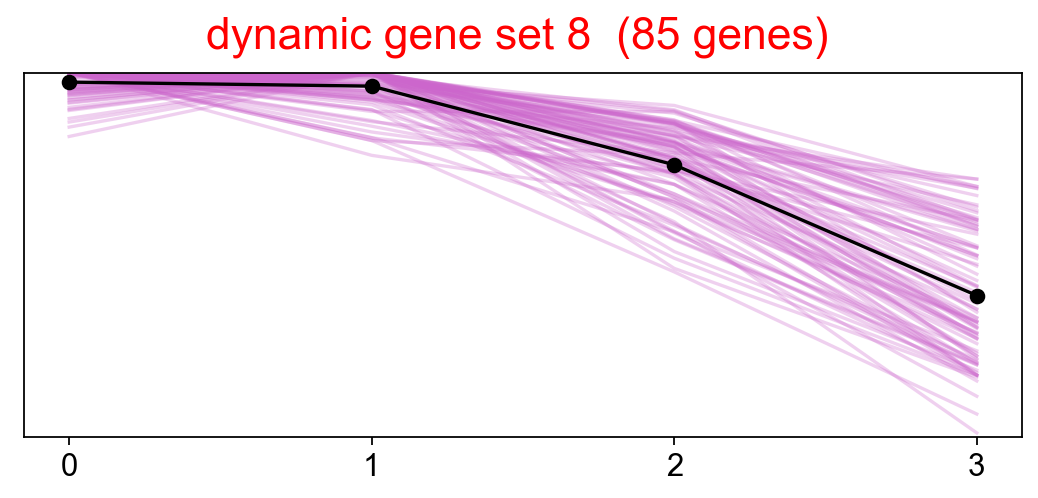

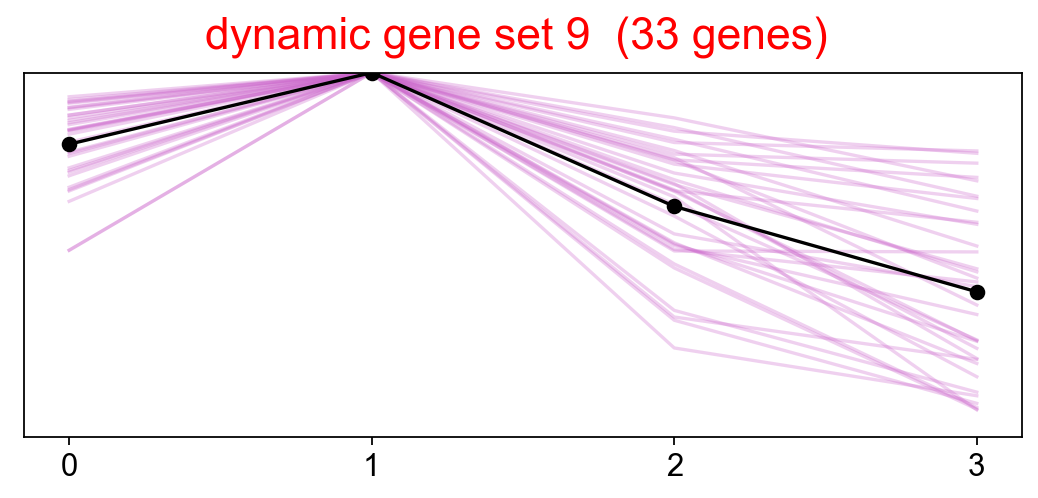

In [59]:
# Plot dynamics of each cluster
for label in range(0, max(labels_HDBSCAN)+1):
    Y = X.loc[labels_HDBSCAN == label]
    
    x = range(4)
    y = np.mean(Y, axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(x, y, marker="o", c="k", zorder=20)
    
    for symbol, row in Y.iterrows():
        ax.plot(x, row, alpha=0.3, c="#cc66cc")
    
    ax.grid(False)
    ax.set_ylim(0,1)
    ax.set_yticks([])
    ax.set_title("dynamic gene set " + str(label+1) + "  (" + str(Y.shape[0]) + " genes) ",y=1.03,size=20, color ='r')
#     ax.set_ylabel("Relative expression")
    ax.set_xticks(x)
#     ax.set_xticklabels(["0h APF", "24h APF", "48h APF", "adult"],size=20)